# **Detection and Decoding Jargon in an Enterprise Corpus**
 
* [Introduction](#introduction)
* [Loading the ES dataset](#Loading)
* [Detecting Jargon](#DetectingJargon)
* [Comparing with historical Query Terms](#Common)
* [Decoding using RoBERTA nearest neighbours](#Roberta)
* [Synonyms for Semantic Search](#SemanticSearch)

# **Introduction**  <a class="anchor"  id="introduction"></a>

The objective of this experiment/study is to devise an algorithm to detect and decode an organisation's Jargon.

I name the algorithm **'JARGES'** (JARGon for Enterprise Search).  It works by comparing frequency of words and phrases in common vocabulary with those in an organisation's corpus.


For example, consider the following sentence located somewhere in the organisation's corpus: 

**"The University's Blackboard VLE can record results via the rubrics scoring scheme":**

The JARGES algorithm flags the words **"blackboard"**, **"vle"** and **"rubrics"** as jargon because they do not occur frequently in common vocabulary BUT have a high TF-IDF in my organisation's corpus)

The words "university", "scoring" and "scheme" are flagged as non-jargon as common (as they are frequently to be found in the common vocabulary reference).


JARGES processes three input files and generates two output lists, as depicted in Figure belwo. These outputs are tailored to enhance distinct components of Enterprise Search (ES):
1. **A ranked list of the organisation’s jargon terms**, ordered by their ‘jargony’ score. This list serves as a ranking function for integration into an LTR model.
2. **A list of synonyms for each jargon term** identified within the organisation. This output enables query expansion in the search engine, thereby improving recall.


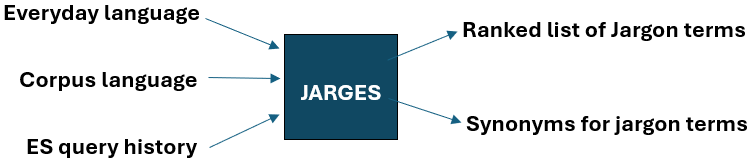


The generated list of jargon terms is large!  This list is refined by comparing the jargon terms to with those query terms previously submitted to the search engine.  The overlapping terms are then used for synonym generation (see Figure 1): -

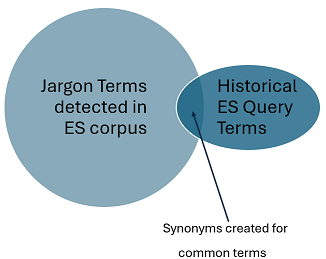

The refined list of terms is then passed to RoBERTa for Language Modelling to produce 'nearest neighbours'.  This list is then coverted in a synonyms.txt file format suitable for use with Apache Solr to unlock Semantic Search.
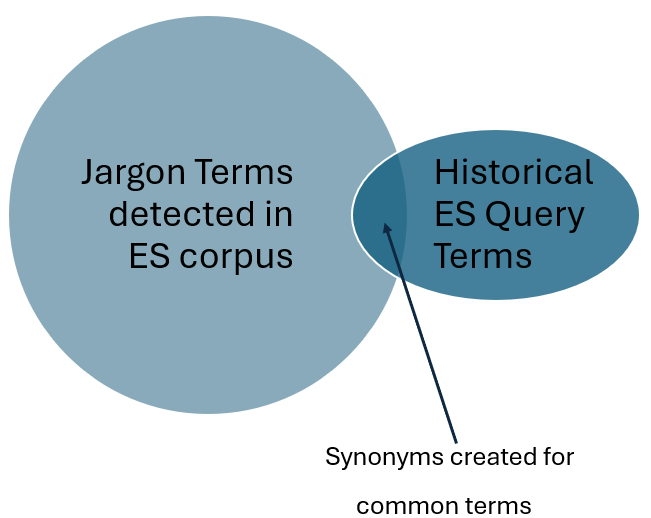

**Limitations**

A word, phrase or abbreviation flagged as jargon in the organisation's corpus will not be used for synonym generation if it has never appeared in ES search history.   This is unlikely as the ES search history was gathered over a two year period and includes 62,044 unique query terms.

If the organisation uses a jargon term that has an alternative meaning in common vocabularly, JARGES will not award it a high 'jargony score'. For example, the term 'cloud' refers to a meteorlogical concern in common parlance, whereas it probably refers to a remote server (Azure, AWS) in a technological organisation.  While RoBERTa embeddings can distinguish context, JARGES uses LM for synonym generation.

In [1]:
#One Off package installations
!pip install spacy scikit-learn wikipedia-api beautifulsoup4 requests
!python -m spacy download en_core_web_sm

  Preparing metadata (setup.py) ... done
  Created wheel for wikipedia-api: filename=Wikipedia_API-0.8.1-py3-none-any.whl size=15383 sha256=bead68e5aa97b331d3c308d193c2c4739b4fede13de11ffc0919bfbd6bbd5a71
  Stored in directory: /root/.cache/pip/wheels/0b/0f/39/e8214ec038ccd5aeb8c82b957289f2f3ab2251febeae5c2860
Successfully built wikipedia-api
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 73.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os

import re
import string
from collections import Counter
import spacy
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import requests
from bs4 import BeautifulSoup
import wikipediaapi

import time
from time import sleep

import torch
from transformers import RobertaModel, RobertaTokenizer
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict
import string
import sys


2025-06-09 05:13:28.685176: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749446008.956073      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749446009.037069      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# debug mode, set to true or false.  
# if true, script will use abbreviated version of corpus file and change top_terms etc to sml values
#debug = False
debug = True

# **Loading the ES Corpus and Query History Files**  <a class="anchor"  id="Loading"></a>


In [4]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

if debug==True:
    # testing with a small file
    !head -5000 /kaggle/input/tcd-corpus/TCD_All_Micro.txt > /kaggle/working/TCD_All_Micro.txt-small
    corpus_file = "/kaggle/working/TCD_All_Micro.txt-small"
else:
    #full corpus
    corpus_file = "/kaggle/input/tcd-corpus/TCD_All_Micro.txt"


/kaggle/input/es-query-history/ws-query-history-v25.txt
/kaggle/input/es-query-history/es-query-history-v25.txt
/kaggle/input/tcd-corpus/TCD_All_Micro.txt


In [5]:
with open(corpus_file, 'r') as file:
    contents = file.read()
    line_count = contents.count('\n')
    print("Corpus lines count:", line_count)

Corpus lines count: 5000


In [6]:
# how many queries has the ES serivce recorded 
!wc -l /kaggle/input/es-query-history/es-query-history-v25.txt

62044 /kaggle/input/es-query-history/es-query-history-v25.txt


In [7]:
if debug==True:
    top_number=100
    
else:
    top_number=1000
    

In [8]:
# Load English language model
nlp = spacy.load("en_core_web_sm")

In [9]:
# Calculate the start time
start = time.time()
print (start)

1749446025.7572513


# **Detecting Jargon**  <a class="anchor"  id="DetectingJargon"></a>

Uses TF-IDF to identify important, domain-specific terms and compares against general English frequencies.  Extracts both single-word and multi-word terms.

In [10]:
class JargonAnalyzer:
    def __init__(self, reference_corpus_path=None):
        """Initialize with optional reference corpus file"""
        self.nlp = spacy.load("en_core_web_sm")
        self.common_words = self._load_common_words()
        self.reference_freq = Counter(self.common_words)
        
        if reference_corpus_path:
            self.update_reference_corpus_from_file(reference_corpus_path)
            
        self.wiki = wikipediaapi.Wikipedia(
            language='en',
            user_agent='JargonAnalyzer/1.0'
        )

    def _load_common_words(self):
        """Load common English words"""
        common_words = {'the', 'be', 'to', 'of', 'and', 'a', 'in', 'that', 'have', 'i'}
        return common_words

    def update_reference_corpus_from_file(self, file_path):
        """Update reference corpus from file"""
        with open(file_path, 'r', encoding='utf-8') as f:
            text = f.read()
        doc = self.nlp(text)
        words = [token.text.lower() for token in doc if token.is_alpha and not token.is_stop]
        self.reference_freq.update(words)

    def _score_terms_from_file(self, file_path):
        """Score terms from file content with robust vectorizer settings"""
        with open(file_path, 'r', encoding='utf-8') as f:
            corpus = [f.read()]
    
        # More flexible vectorizer configuration
        vectorizer = TfidfVectorizer(
            ngram_range=(1, 3),
            stop_words='english',
            min_df=1,           # Term must appear in at least 1 document
            max_df=1.0,         # Term can appear in up to 100% of documents
            max_features=10000  # Limit number of features
        )
    
        try:
            X = vectorizer.fit_transform(corpus)
            terms = vectorizer.get_feature_names_out()
            scores = np.asarray(X.mean(axis=0)).ravel()
            return list(zip(terms, scores))
        except ValueError as e:
            print(f"Vectorization error: {e}")
            return []
        

    def get_term_definition(self, term):
        """Return the first sentence from the Wikipedia summary of the term."""
        try:
            sleep(1)  # Respect API rate limits
            page = self.wiki.page(term)
            if page.exists():
                first_sentence = page.summary.split('. ')[0].strip()
                return first_sentence + '.' if not first_sentence.endswith('.') else first_sentence
            return None
        except Exception:
            return None


    def analyze_file(self, file_path, top_n=top_number):
        """Analyze jargon terms in a file"""
        scored_terms = self._score_terms_from_file(file_path)
        results = []
        
        for term, score in sorted(scored_terms, key=lambda x: x[1], reverse=True)[:top_n*3]:
            if term in self.reference_freq or len(term) < 3:
                continue
                
            explanation = self.get_term_definition(term) or "Jargon term"
            results.append((term, round(float(score), 4), explanation))
            
            if len(results) >= top_n:
                break
                
        return results

    def generate_glossary(self, file_path, output_file="glossary.md"):
        """Generate glossary from file"""
        terms = self.analyze_file(file_path)
        
        #with open(output_file, 'w', encoding='utf-8') as f:
         #   f.write("# Domain Terminology Glossary\n\n")
         #   f.write("| Term | Score | Definition |\n")f
         #   f.write("|------|-------|------------|\n")
            
          #  for term, score, explanation in terms:
          #     f.write(f"| {term} | {score:.4f} | {explanation} |\n")

        with open(output_file, 'w', encoding='utf-8') as f:
            f.write("# Jargon Term | Jargony Score | Definition |\n")
            f.write("|------|-------|---------------|\n")
            
            for term, score, explanation in terms:
               f.write(f" {term} \t {score:.4f} \t {explanation} \n")

# Example usage
if __name__ == "__main__":
    analyzer = JargonAnalyzer()
    
    results = analyzer.analyze_file(corpus_file)
    
    print(f"#Top {len(results)} jargon terms:")
    #for term, score, explanation in results:
    #   print(f"{term} \t ({score:.4f})")
    
    
    # Save glossary
    analyzer.generate_glossary(corpus_file, "/kaggle/working/corpus_glossary.txt")

#Top 100 jargon terms:


In [11]:
end = time.time()
length = end - start

# Time taken to execut the JargonAnalyser (circa 31 min for full corpus, 109 min for n=5000)
print("JargonAnalyser took", length/60, "minutes!")

JargonAnalyser took 3.9790783166885375 minutes!


# **Comparing Jargon terms with Historical ES Query terms**  <a class="anchor"  id="Compare"></a>


In [12]:
def get_common_terms_from_files(tsv_file, list_file, output_file=None):
    """
    Compare terms from two files and find common entries.
    
    Args:
        tsv_file (str): Path to tab-separated file (uses first column)
        list_file (str): Path to file with one term per line
        output_file (str, optional): If provided, saves results to this file
    """
    # Read the tab-separated file (first column only)
    tsv_terms = set()
    with open(tsv_file, 'r') as f:
        for line in f:
            term = line.split('\t')[0].strip().lower()
            if term:  # ignore empty terms
                tsv_terms.add(term)

    # Read the list file (one term per line)
    list_terms = set()
    with open(list_file, 'r') as f:
        for line in f:
            #term = line.strip().lower()
            term = line.split('\t')[0].strip().lower()
            if term:  # ignore empty lines
                list_terms.add(term)

    # Find intersection
    #common_terms = sorted(tsv_terms & list_terms)
    common_terms = sorted([term for term in tsv_terms & list_terms if not term[0].isdigit()])

    # Print results
    print(f"Total terms in {tsv_file}: {len(tsv_terms)}")
    print(f"Total terms in {list_file}: {len(list_terms)}")
    print(f"Common terms found: {len(common_terms)}")

    if common_terms:
        print("\nCommon terms:")
        #for term in common_terms:
            #print(term)

        # Save to file if requested
        if output_file:
            with open(output_file, 'w') as f:
                f.write("\n".join(common_terms))
            print(f"\nResults saved to {output_file}")
    else:
        print("No common terms found.")



In [13]:
#!head -5 /kaggle/input/es-query-history/es-query-history-v25.txt

In [14]:
#!head -5 /kaggle/working/corpus_glossary.txt

In [15]:
get_common_terms_from_files(
    tsv_file="/kaggle/working/corpus_glossary.txt",          # Tab-separated file
    list_file="/kaggle/input/es-query-history/es-query-history-v25.txt",     # One term per line
    output_file="/kaggle/working/refined-jargon-list.txt"  
)

Total terms in /kaggle/working/corpus_glossary.txt: 190
Total terms in /kaggle/input/es-query-history/es-query-history-v25.txt: 62037
Common terms found: 48

Common terms:

Results saved to /kaggle/working/refined-jargon-list.txt


In [16]:
!wc -l "/kaggle/working/corpus_glossary.txt"
!wc -l "/kaggle/working/refined-jargon-list.txt"

204 /kaggle/working/corpus_glossary.txt
47 /kaggle/working/refined-jargon-list.txt


In [17]:
#raise SystemExit("Exiting Script here")
print("Exiting the script cleanly.")
sys.exit(0)  # 0 indicates success, non-zero for errors

Exiting the script cleanly.


SystemExit: 0

/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


# **RoBERTa nearest neighbours**  <a class="anchor"  id="Roberta"></a>


In [ ]:
# Inputs and outputs
#corpus_file = "/kaggle/working/TCD_All_Micro.txt-small"      # ES corpus (one sentence per line)
#corpus_file = "/kaggle/input/tcd-corpus/TCD_All_Micro.txt"      # ES corpus (one sentence per line)
query_file = "/kaggle/working/refined-jargon-list.txt"       # One query word per line
output_file = "/kaggle/working/synonyms.txt"     # Solr-compatible output

In [ ]:
# Initialize RoBERTa
model_name = 'roberta-base'
tokenizer = RobertaTokenizer.from_pretrained(model_name)
model = RobertaModel.from_pretrained(model_name)
model.eval()

In [ ]:
def preprocess_text(text):
    """Lowercase and remove punctuation."""
    text = text.lower().translate(str.maketrans('', '', string.punctuation))
    return text


In [ ]:
def get_word_embeddings(corpus_file, max_words=10000):
    """Extract word embeddings line by line."""
    word_counts = defaultdict(int)
    word_embeddings = defaultdict(list)

    with open(corpus_file, 'r', encoding='utf-8') as f:
        for line in f:
            line = preprocess_text(line)
            inputs = tokenizer(line, return_tensors="pt", truncation=True, padding=True)
            with torch.no_grad():
                outputs = model(**inputs)
            embeddings = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

            for word in line.split():
                if word in tokenizer.get_vocab() and word_counts[word] < 10:
                    word_embeddings[word].append(embeddings)
                    word_counts[word] += 1
                if len(word_embeddings) >= max_words:
                    break

    # Average embeddings per word
    return {word: np.mean(embs, axis=0) for word, embs in word_embeddings.items()}

# **Synonyms for Semantic Search**  <a class="anchor"  id="SemanticSearch"></a>

In [ ]:
def find_synonyms(query_words, word_embeddings, top_k=5, similarity_threshold=0.7):
    """Find synonyms for each query word (Solr format)."""
    results = {}
    for word in query_words:
        if word not in word_embeddings:
            continue
        query_embed = word_embeddings[word].reshape(1, -1)
        similarities = {
            w: cosine_similarity(query_embed, e.reshape(1, -1))[0][0]
            for w, e in word_embeddings.items() if w != word
        }
        # Filter by similarity threshold and get top_k
        filtered = [(w, sim) for w, sim in similarities.items() if sim >= similarity_threshold]
        filtered.sort(key=lambda x: x[1], reverse=True)
        synonyms = [w for w, sim in filtered[:top_k]]
        if synonyms:
            results[word] = synonyms
    return results

In [ ]:
# Calculate the start time
start = time.time()

In [ ]:
# Read query words
with open(query_file, 'r', encoding='utf-8') as f:
    query_words = [preprocess_text(line.strip()) for line in f if line.strip()]

print("Generating embeddings...")
word_embeddings = get_word_embeddings(corpus_file)

print("\nFinding synonyms (Solr format)...")
synonyms = find_synonyms(query_words, word_embeddings)

# Write to Solr synonyms.txt format
with open(output_file, 'w', encoding='utf-8') as f:
    for word, syns in synonyms.items():
        line = f"{word}, {', '.join(syns)}\n"
        f.write(line)
    
print(f"\nDone! Solr synonyms saved to {output_file}.")

In [ ]:
end = time.time()
length = end - start

# Time taken to execute the above (circa 31 min for full corpus, 109 min for n=5000)
print("RoBERTa embeddings took", length/60, "minutes!")

In [ ]:
!wc -l /kaggle/working/synonyms.txt
!head -50 /kaggle/working/synonyms.txt